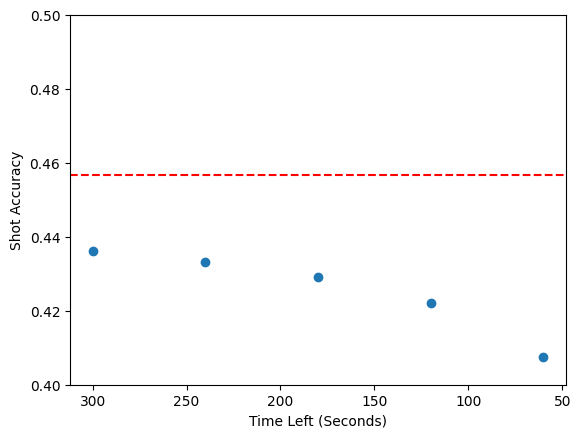

In [1]:
%run Data.ipynb
%run Code/Court.ipynb

In [2]:
shot_df

SEASON_1 SEASON_2     TEAM_ID         TEAM_NAME_x  PLAYER_ID  \
0            2023  2022-23  1610612764  Washington Wizards     203078   
1            2023  2022-23  1610612764  Washington Wizards     204001   
2            2023  2022-23  1610612764  Washington Wizards    1628420   
3            2023  2022-23  1610612764  Washington Wizards     204001   
4            2023  2022-23  1610612764  Washington Wizards    1630166   
...           ...      ...         ...                 ...        ...   
4012475      2004  2003-04  1610612755  Philadelphia 76ers       2422   
4012476      2004  2003-04  1610612759   San Antonio Spurs       1938   
4012477      2004  2003-04  1610612747  Los Angeles Lakers        406   
4012478      2004  2003-04  1610612756        Phoenix Suns       2063   
4012479      2004  2003-04  1610612748          Miami Heat       2548   

                PLAYER_NAME POSITION_GROUP POSITION  GAME_DATE   GAME_ID  ...  \
0              Bradley Beal              G       SG 2022-10-19  22200004  ...   
1        Kristaps Porzingis              C        C 2022-10-19  22200004  ...   
2              Monte Morris              G       PG 2022-10-19  22200004  ...   
3        Kristaps Porzingis              C        C 2022-10-19  22200004  ...   
4               Deni Avdija              F       SF 2022-10-19  22200004  ...   
...                     ...            ...      ...        ...       ...  ...   
4012475        John Salmons              G       SG 2003-10-28  20300001  ...   
4012476       Manu Ginobili              G       SG 2003-10-28  20300002  ...   
4012477    Shaquille O'Neal              C        C 2003-10-28  20300003  ...   
4012478        Jake Voskuhl              C        C 2003-10-28  20300002  ...   
4012479         Dwyane Wade              G       PG 2003-10-28  20300001  ...   

        SHOT_VALUE ACTION_GROUP           HOME_FULL           AWAY_FULL  \
0                3    jump shot      Indiana Pacers  Washington Wizards   
1                0    jump shot      Indiana Pacers  Washington Wizards   
2                2   layup shot      Indiana Pacers  Washington Wizards   
3                2    dunk shot      Indiana Pacers  Washington Wizards   
4                2    dunk shot      Indiana Pacers  Washington Wizards   
...            ...          ...                 ...                 ...   
4012475          3    jump shot  Philadelphia 76ers          Miami Heat   
4012476          0    jump shot   San Antonio Spurs        Phoenix Suns   
4012477          0    jump shot  Los Angeles Lakers    Dallas Mavericks   
4012478          0   layup shot   San Antonio Spurs        Phoenix Suns   
4012479          0   layup shot  Philadelphia 76ers          Miami Heat   

                   OPPONENT E_DEF_RATING DEF_RATING CLUTCH BUZZER   HOME  
0            Indiana Pacers        115.4      117.1  False  False  False  
1            Indiana Pacers        115.4      117.1  False  False  False  
2            Indiana Pacers        115.4      117.1  False  False  False  
3            Indiana Pacers        115.4      117.1  False  False  False  
4            Indiana Pacers        115.4      117.1  False  False  False  
...                     ...          ...        ...    ...    ...    ...  
4012475          Miami Heat         98.9      100.3  False  False   True  
4012476        Phoenix Suns        102.2      104.2  False  False   True  
4012477    Dallas Mavericks        104.3      105.9  False  False   True  
4012478   San Antonio Spurs         91.6       93.1  False  False  False  
4012479  Philadelphia 76ers         99.1      100.4  False  False  False  

[4012480 rows x 40 columns]

In [3]:
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from scipy.stats import randint, uniform, beta
from sklearn.metrics import mean_squared_error, r2_score, precision_recall_curve, average_precision_score, f1_score, accuracy_score, precision_score, recall_score, mean_absolute_error
from sklearn.linear_model import LogisticRegression, LinearRegression, Lasso
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor
import xgboost as xgb
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn import tree
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers.legacy import Adam
from tensorflow.keras.callbacks import EarlyStopping
import tensorflow as tf
import math
from math import sqrt
import pickle

# Pre-Merge Regression Models

In [4]:
#we'll drop position from this initial model because it has so many variations that are rare that may mess up the model
basic_df = shot_df[shot_df['SEASON_1'] == 2023]
X = basic_df[['POSITION_GROUP', 'ACTION_TYPE','SHOT_TYPE','BASIC_ZONE','ZONE_NAME','LOC_X','LOC_Y','SHOT_DISTANCE','QUARTER','SCORE_DIFF','HOME','TIME_LEFT_QUARTER','TIME_LEFT_GAME']]
y = basic_df['SHOT_MADE']

#We have 4,000,000 data points for early model we'll make the dataset smaller for quicker/easier training before train-test split
#new_X, X_trash, new_y, y_trash = train_test_split(X, y, test_size=0.975, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [5]:
# Define the column transformer to apply one hot encoding only to categorical features
preprocessor = ColumnTransformer(
    transformers=[
        ('cat',  OneHotEncoder(), ['POSITION_GROUP', 'ACTION_TYPE','SHOT_TYPE','BASIC_ZONE','ZONE_NAME','QUARTER','HOME'])
    ])

# Create a pipeline with one hot encoding and logistic regression (automatically uses ridge regression penalty)
model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression())
])

In [6]:
param_grid = {
    'classifier__C': [0.01, 0.1, 1, 10, 100],
    'classifier__penalty': ['l1', 'l2', None],
    'classifier__solver': ['saga'],
    'classifier__max_iter': [100, 300, 500, 1000],
}


grid_search = GridSearchCV(model, param_grid, cv=5, n_jobs=-1,error_score='raise')
grid_search.fit(X_train, y_train)

best_params = grid_search.best_params_
print(f'Best Parameters: {best_params}')

# Use the best parameters to create the final model
final_model = grid_search.best_estimator_

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1181: UserWarning: Setting penalty

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1181: UserWarning: Setting penal

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_

Best Parameters: {'classifier__C': 0.01, 'classifier__max_iter': 100, 'classifier__penalty': None, 'classifier__solver': 'saga'}


In [7]:
lasso_coefficients = final_model.named_steps['classifier'].coef_
print(f'Lasso Coefficients: {lasso_coefficients}')

Lasso Coefficients: [[-0.00917506 -0.10423574 -0.08305203  1.2708565  -0.20285506  1.48237838
   0.57899337 -0.08890033 -0.43580946  0.35554968 -0.32023727 -0.30977424
  -0.55216059 -0.81847439 -0.88505008  0.74907642 -0.74453838  0.84055462
   0.03332198 -0.54834833 -0.17742658 -0.5189096  -0.07415424 -0.51334511
  -0.14227758 -0.4228895  -0.89145782 -0.42075408  1.34440892 -0.2685721
   0.69963544 -0.2846559   1.49359286 -0.17505677  1.54528937  0.17723587
  -0.26778625 -0.47309393 -0.33079777  1.15087841 -0.25806984  0.12358117
  -0.40677469  0.79720327 -1.09720224 -0.21892466  0.37088624  0.07859401
  -0.48738789 -0.41948524 -0.53332942 -0.10998702 -0.0864758  -0.37833803
  -0.40547703  0.1321993  -0.18985951 -0.03286055  0.90264129 -0.2247683
  -2.66761283  0.48084269  0.45308854  0.51667021  0.50080011  0.51974846
   0.02274941 -0.02799783  0.01448632 -0.0570203  -0.14868043 -0.10470916
  -0.09175366]]


In [8]:
# Assuming 'preprocessor' is the first step in your pipeline
preprocessor.fit(X_train)
transformed_feature_names = preprocessor.get_feature_names_out(input_features=X_train.columns)
coefficients_df = pd.DataFrame({'Feature': transformed_feature_names, 'Coefficient': lasso_coefficients[0]})
#Selected variables
coefficients_df[coefficients_df['Coefficient'] != 0]

Feature  Coefficient
0                   cat__POSITION_GROUP_C    -0.009175
1                   cat__POSITION_GROUP_F    -0.104236
2                   cat__POSITION_GROUP_G    -0.083052
3    cat__ACTION_TYPE_Alley Oop Dunk Shot     1.270856
4   cat__ACTION_TYPE_Alley Oop Layup shot    -0.202855
..                                    ...          ...
68                         cat__QUARTER_3     0.014486
69                         cat__QUARTER_4    -0.057020
70                         cat__QUARTER_5    -0.148680
71                          cat__HOME_0.0    -0.104709
72                          cat__HOME_1.0    -0.091754

[73 rows x 2 columns]

In [9]:
y_pred = final_model.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")

Accuracy: 0.6258861983242795


In [10]:
X['SHOT_VALUE'] = np.where(X['SHOT_TYPE']=='3PT Field Goal', y * 3, y * 2)
basic_df['SHOT_VALUE'] = np.where(basic_df['SHOT_TYPE']=='3PT Field Goal', basic_df['SHOT_MADE'] * 3, basic_df['SHOT_MADE'] * 2)

/var/folders/5d/x77440zn3c332t6t3c7wdsnm0000gn/T/ipykernel_41072/3991497345.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['SHOT_VALUE'] = np.where(X['SHOT_TYPE']=='3PT Field Goal', y * 3, y * 2)
/var/folders/5d/x77440zn3c332t6t3c7wdsnm0000gn/T/ipykernel_41072/3991497345.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  basic_df['SHOT_VALUE'] = np.where(basic_df['SHOT_TYPE']=='3PT Field Goal', basic_df['SHOT_MADE'] * 3, basic_df['SHOT_MADE'] * 2)


In [11]:
X_lin = X.iloc[:, :-1]
y_lin = X['SHOT_VALUE']

#We have almost 4,000,000 data points for early model we'll make the dataset smaller for quicker/easier training before train-test split
#new_X, X_trash, new_y, y_trash = train_test_split(X_lin, y_lin, test_size=0.975, random_state=42)
X_train_lin, X_test_lin, y_train_lin, y_test_lin = train_test_split(X_lin, y_lin, test_size=0.2, random_state=42)

In [12]:
model = Pipeline(steps=[('preprocessor', preprocessor),
                        ('regressor', LinearRegression(n_jobs=-1))])


# Fit the model to the training data
model.fit(X_train_lin, y_train_lin)

# Make predictions on the test data
y_pred = model.predict(X_test_lin)

# Evaluate the model
mse = mean_squared_error(y_test_lin, y_pred)
r2 = r2_score(y_test_lin, y_pred)

print(f'Mean Squared Error: {mse:.2f}')
print(f'R-squared: {r2:.2f}')

Mean Squared Error: 1.35
R-squared: 0.04


In [13]:
lasso_model = Lasso()

model = Pipeline(steps=[('preprocessor', preprocessor),
                        ('regressor', lasso_model)])


# Set up a parameter grid for grid search
param_grid = {
    'regressor__alpha': [0.01, 0.1, 1.0, 10.0]  # Add more values as needed
}

# Create a grid search object
grid_search = GridSearchCV(model, param_grid, cv=5, scoring='neg_mean_squared_error')

# Fit the grid search to the training data
grid_search.fit(X_train_lin, y_train_lin)

# Print the best parameters and best score
print("Best Parameters:", grid_search.best_params_)
print("Best Negative Mean Squared Error:", grid_search.best_score_)

# Get the best model from the grid search
best_model = grid_search.best_estimator_

lasso_coefficients = best_model.named_steps['regressor'].coef_
print(f'Lasso Coefficients: {lasso_coefficients}')

# Make predictions on the test data using the best model
y_pred = best_model.predict(X_test_lin)

# Evaluate the best model
mse = mean_squared_error(y_test_lin, y_pred)
r2 = r2_score(y_test_lin, y_pred)

print(f'Mean Squared Error: {mse:.2f}')
print(f'R-squared: {r2:.2f}')

Best Parameters: {'regressor__alpha': 0.01}
Best Negative Mean Squared Error: -1.3748683729156115
Lasso Coefficients: [ 0.00000000e+00 -0.00000000e+00 -0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
 -0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
 -0.00000000e+00 -0.00000000e+00 -1.38988692e-01  0.00000000e+00
 -0.00000000e+00  0.00000000e+00  0.00000000e+00 -0.00000000e+00
  0.00000000e+00 -0.00000000e+00  0.00000000e+00 -0.00000000e+00
  0.00000000e+00  0.00000000e+00 -0.00000000e+00 -0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00 -0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00 -0.00000000e+00  0.00000000e+00
 -0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
 -0.00000000e+00 -0.00000000e+00 -0.00000000e+00 -1.03196724e-01
  2.83993253e-12  0.00000000e+00 -0.0

In [14]:
# Assuming 'preprocessor' is the first step in your pipeline
transformed_feature_names = preprocessor.get_feature_names_out(input_features=X_train_lin.columns)
coefficients_df = pd.DataFrame({'Feature': transformed_feature_names, 'Coefficient': lasso_coefficients})
#Selected variables
coefficients_df[coefficients_df['Coefficient'] != 0]

Feature   Coefficient
14  cat__ACTION_TYPE_Driving Layup Shot -1.389887e-01
51        cat__SHOT_TYPE_2PT Field Goal -1.031967e-01
52        cat__SHOT_TYPE_3PT Field Goal  2.839933e-12
57            cat__BASIC_ZONE_Mid-Range -2.531672e-02
58      cat__BASIC_ZONE_Restricted Area  3.761686e-01

# Post-Merge Regression Models

In [15]:
#we'll drop position from this initial model because it has so many variations that are rare that may mess up the model
df_23 = shot_df[shot_df['SEASON_1']==2023]
X = df_23[['POSITION_GROUP', 'ACTION_TYPE','SHOT_TYPE','BASIC_ZONE','ZONE_NAME','LOC_X','LOC_Y','SHOT_DISTANCE','QUARTER','SCORE_DIFF','HOME','TIME_LEFT_QUARTER','TIME_LEFT_GAME', 'CLUTCH','BUZZER','E_DEF_RATING','DEF_RATING']]
y = df_23['SHOT_MADE']

#We have 4,000,000 data points for early model we'll make the dataset smaller for quicker/easier training before train-test split
#new_X, X_trash, new_y, y_trash = train_test_split(X, y, test_size=0.975, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [16]:
# Define the column transformer to apply one hot encoding only to categorical features
preprocessor = ColumnTransformer(
    transformers=[
        ('cat',  OneHotEncoder(), ['POSITION_GROUP', 'ACTION_TYPE','SHOT_TYPE','BASIC_ZONE','ZONE_NAME','QUARTER','HOME','CLUTCH','BUZZER'])
    ])

# Create a pipeline with one hot encoding and logistic regression (automatically uses ridge regression penalty)
model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression())
    ])

In [17]:
param_grid = {
    'classifier__C': [0.01, 0.1, 1, 10, 100],
    'classifier__penalty': ['l1', 'l2', None],
    'classifier__solver': ['saga'],
    'classifier__max_iter': [100, 300, 500, 1000],
}


grid_search = GridSearchCV(model, param_grid, cv=5, n_jobs=-1,error_score='raise')
grid_search.fit(X_train, y_train)

best_params = grid_search.best_params_
print(f'Best Parameters: {best_params}')

# Use the best parameters to create the final model
final_model = grid_search.best_estimator_

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1181: UserWarning: Setting penalty

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1181: UserWarning: Setting penal

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1181: UserWarning: Setting

Best Parameters: {'classifier__C': 0.1, 'classifier__max_iter': 100, 'classifier__penalty': 'l2', 'classifier__solver': 'saga'}


In [18]:
y_pred = final_model.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")

Accuracy: 0.6258401620476935


In [19]:
lasso_coefficients = final_model.named_steps['classifier'].coef_
print(f'Lasso Coefficients: {lasso_coefficients}')

Lasso Coefficients: [[ 0.02660489 -0.07094796 -0.04915753  1.2120718  -0.13208884  1.46255699
   0.56188829 -0.03091881 -0.32468788  0.40241832 -0.25369817 -0.23158881
  -0.47484309 -0.72773223 -0.82140705  0.23278247 -0.66831018  0.84350849
   0.08436632 -0.4633336  -0.10444395 -0.44282412 -0.00885872 -0.43451351
  -0.05150654 -0.35760456 -0.8258351  -0.34566799  1.108915   -0.20447308
   0.43237941 -0.21764186  1.16521176 -0.08259504  1.50068247  0.22745123
  -0.20326903 -0.41274295 -0.25402919  0.25408679 -0.18741487  0.11823808
  -0.33122912  0.76662929 -1.01992493 -0.12605441  0.36845813  0.10501622
  -0.40403939 -0.34724403 -0.44964062  0.07216374 -0.16566435 -0.16009614
  -0.80603862  0.07560706  0.02812872 -0.08497214  0.86316137 -0.00929085
  -1.09161215  0.18865731  0.15672449  0.22173851  0.20538456  0.22560668
   0.03363203 -0.01674256  0.02569825 -0.03980367 -0.09628466 -0.05328595
  -0.04021466 -0.01428658 -0.07921403  0.19169115 -0.28519176]]


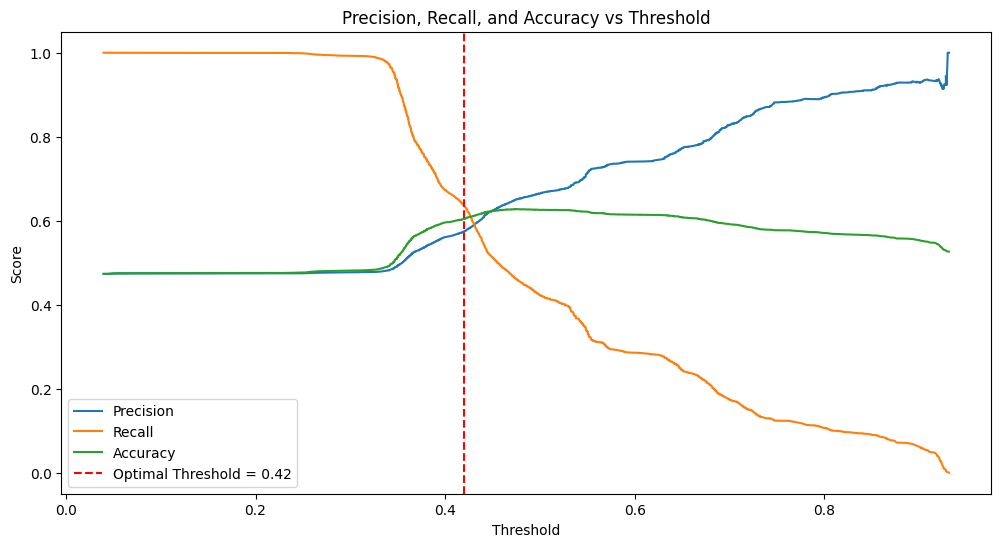

In [20]:
y_probs = final_model.predict_proba(X_test)[:, 1]

# Calculate precision-recall curve
precision, recall, thresholds = precision_recall_curve(y_test, y_probs)

# Calculate F1-score for each threshold
f1_scores = [f1_score(y_test, y_probs >= t) for t in thresholds]

optimal_threshold = 0.42

# Plot Precision, Recall, and Accuracy vs Threshold
plt.figure(figsize=(12, 6))
plt.plot(thresholds, precision[:-1], label='Precision')
plt.plot(thresholds, recall[:-1], label='Recall')
plt.plot(thresholds, [np.sum((y_probs >= t) == y_test) / len(y_test) for t in thresholds], label='Accuracy')
plt.axvline(x=optimal_threshold, color='r', linestyle='--', label=f'Optimal Threshold = {optimal_threshold:.2f}')
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.legend()
plt.title('Precision, Recall, and Accuracy vs Threshold')
plt.show()
#Red line is optimal threshold

In [21]:
y_pred_optimal_threshold = (y_probs >= optimal_threshold).astype(int)

# Evaluate the model with the optimal threshold
precision_optimal = precision_score(y_test, y_pred_optimal_threshold)
recall_optimal = recall_score(y_test, y_pred_optimal_threshold)
accuracy_optimal = accuracy_score(y_test, y_pred_optimal_threshold)

# Display evaluation metrics
print(f'Optimal Threshold: {optimal_threshold:.2f}')
print(f'Precision: {precision_optimal:.2f}')
print(f'Recall: {recall_optimal:.2f}')
print(f'Accuracy: {accuracy_optimal:.2f}')

Optimal Threshold: 0.42
Precision: 0.57
Recall: 0.64
Accuracy: 0.60


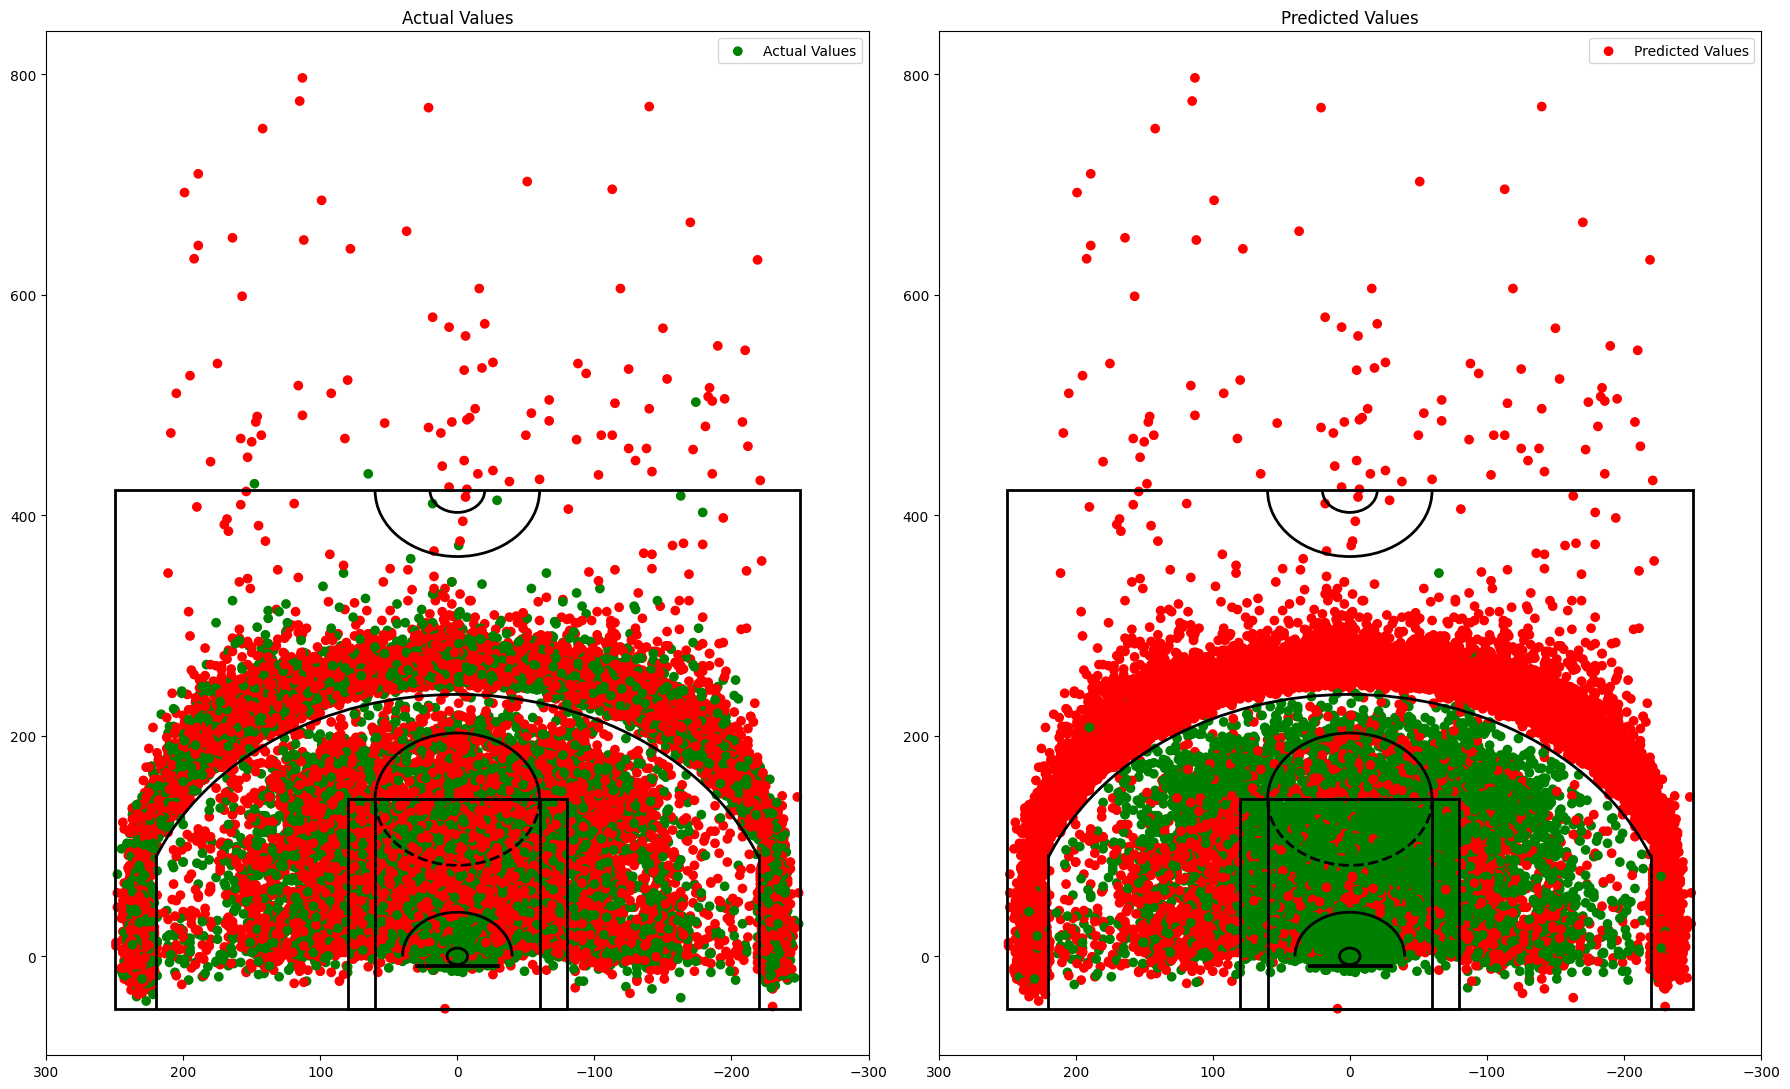

In [22]:
fig, axes = plt.subplots(1, 2, figsize=(18, 11))

# Plot Actual Values
col = np.where(y_test, 'g', 'r')
axes[0].scatter(X_test.LOC_X * 10, (X_test.LOC_Y-5)*10, c=col, label='Actual Values')
draw_court(outer_lines=True, ax=axes[0])  # Assuming draw_court accepts an ax parameter
axes[0].set_xlim(300, -300)
axes[0].set_title('Actual Values')
axes[0].legend()

# Plot Predicted Values
X_test['PREDICTION'] = y_pred_optimal_threshold
col = np.where(X_test["PREDICTION"], 'g', 'r')
axes[1].scatter(X_test.LOC_X * 10, (X_test.LOC_Y-5)*10, c=col, label='Predicted Values')
draw_court(outer_lines=True, ax=axes[1])  # Assuming draw_court accepts an ax parameter
axes[1].set_xlim(300, -300)
axes[1].set_title('Predicted Values')
axes[1].legend()

# Adjust layout
plt.tight_layout()

# Show the plots
plt.show()

In [23]:
X['SHOT_VALUE'] = np.where(X['SHOT_TYPE']=='3PT Field Goal', y * 3, y * 2)

/var/folders/5d/x77440zn3c332t6t3c7wdsnm0000gn/T/ipykernel_41072/3257058238.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['SHOT_VALUE'] = np.where(X['SHOT_TYPE']=='3PT Field Goal', y * 3, y * 2)


In [24]:
X_lin = X.iloc[:, :-1]
y_lin = X['SHOT_VALUE']

#We have almost 4,000,000 data points for early model we'll make the dataset smaller for quicker/easier training before train-test split
#new_X, X_trash, new_y, y_trash = train_test_split(X_lin, y_lin, test_size=0.975, random_state=42)
X_train_lin, X_test_lin, y_train_lin, y_test_lin = train_test_split(X_lin, y_lin, test_size=0.2, random_state=42)

In [25]:
model = Pipeline(steps=[('preprocessor', preprocessor),
                        ('regressor', LinearRegression(n_jobs=-1))])


# Fit the model to the training data
model.fit(X_train_lin, y_train_lin)

# Make predictions on the test data
y_pred_lin = model.predict(X_test_lin)

# Evaluate the model
mse = mean_squared_error(y_test_lin, y_pred_lin)
r2 = r2_score(y_test_lin, y_pred_lin)

print(f'Mean Squared Error: {mse:.2f}')
print(f'R-squared: {r2:.2f}')

Mean Squared Error: 1.35
R-squared: 0.04


In [26]:
lasso_model = Lasso()

model = Pipeline(steps=[('preprocessor', preprocessor),
                        ('regressor', lasso_model)])


# Set up a parameter grid for grid search
param_grid = {
    'regressor__alpha': [0.01, 0.1, 1.0, 10.0]  # Add more values as needed
}

# Create a grid search object
grid_search = GridSearchCV(model, param_grid, cv=5, scoring='neg_mean_squared_error')

# Fit the grid search to the training data
grid_search.fit(X_train_lin, y_train_lin)

# Print the best parameters and best score
print("Best Parameters:", grid_search.best_params_)
print("Best Negative Mean Squared Error:", grid_search.best_score_)

# Get the best model from the grid search
best_model = grid_search.best_estimator_

lasso_coefficients = best_model.named_steps['regressor'].coef_
print(f'Lasso Coefficients: {lasso_coefficients}')

# Make predictions on the test data using the best model
y_pred = best_model.predict(X_test_lin)

# Evaluate the best model
mse = mean_squared_error(y_test_lin, y_pred)
r2 = r2_score(y_test_lin, y_pred)

print(f'Mean Squared Error: {mse:.2f}')
print(f'R-squared: {r2:.2f}')

Best Parameters: {'regressor__alpha': 0.01}
Best Negative Mean Squared Error: -1.3748683729156115
Lasso Coefficients: [ 0.00000000e+00 -0.00000000e+00 -0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
 -0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
 -0.00000000e+00 -0.00000000e+00 -1.38988692e-01  0.00000000e+00
 -0.00000000e+00  0.00000000e+00  0.00000000e+00 -0.00000000e+00
  0.00000000e+00 -0.00000000e+00  0.00000000e+00 -0.00000000e+00
  0.00000000e+00  0.00000000e+00 -0.00000000e+00 -0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00 -0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00 -0.00000000e+00  0.00000000e+00
 -0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
 -0.00000000e+00 -0.00000000e+00 -0.00000000e+00 -1.03196724e-01
  2.83993253e-12  0.00000000e+00 -0.0

In [27]:
# Assuming 'preprocessor' is the first step in your pipeline
transformed_feature_names = preprocessor.get_feature_names_out(input_features=X_train_lin.columns)
coefficients_df = pd.DataFrame({'Feature': transformed_feature_names, 'Coefficient': lasso_coefficients})
#Selected variables
coefficients_df[coefficients_df['Coefficient'] != 0]

Feature   Coefficient
14  cat__ACTION_TYPE_Driving Layup Shot -1.389887e-01
51        cat__SHOT_TYPE_2PT Field Goal -1.031967e-01
52        cat__SHOT_TYPE_3PT Field Goal  2.839933e-12
57            cat__BASIC_ZONE_Mid-Range -2.531672e-02
58      cat__BASIC_ZONE_Restricted Area  3.761686e-01

# Tree-Based Ensemble Models

In [28]:
selected_features = ['SEASON_1', 'POSITION_GROUP', 'ACTION_GROUP', 'SHOT_TYPE', 'BASIC_ZONE',
                    'LOC_X', 'LOC_Y', 'SHOT_DISTANCE', 'DEF_RATING', 'HOME', 'SHOT_MADE']

In [29]:
X = shot_df[selected_features]
y = shot_df['SHOT_MADE']

X = pd.get_dummies(X)

train_years = [2017, 2018, 2019, 2020, 2021, 2022]
test_years = [2023]

train_set = X[X['SEASON_1'].isin(train_years)].copy()
test_set = X[X['SEASON_1'].isin(test_years)].copy()

X_train = train_set.drop(['SHOT_MADE', 'SEASON_1'], axis=1)
y_train = train_set['SHOT_MADE']

X_test = test_set.drop(['SHOT_MADE', 'SEASON_1'], axis=1)
y_test = test_set['SHOT_MADE']

In [30]:
rf_model = RandomForestRegressor()
rf_model.fit(X_train, y_train)

predictions = rf_model.predict(X_test)

mae = mean_absolute_error(y_test, predictions)
mse = mean_squared_error(y_test, predictions)
rmse = sqrt(mse)

feature_importances = rf_model.feature_importances_

print(f'Mean Absolute Error (MAE): {mae:.4f}')
print(f'Mean Squared Error (MSE): {mse:.4f}')
print(f'Root Mean Squared Error (RMSE): {rmse:.4f}')

feature_importance_df = pd.DataFrame({'Feature': X_train.columns, 'Importance': feature_importances})
print('\nFeature Importances:')
print(feature_importance_df.sort_values(by='Importance', ascending=False)[:10])

Mean Absolute Error (MAE): 0.4597
Mean Squared Error (MSE): 0.2565
Root Mean Squared Error (RMSE): 0.5065

Feature Importances:
                    Feature  Importance
0                     LOC_X    0.285188
1                     LOC_Y    0.255323
3                DEF_RATING    0.239130
2             SHOT_DISTANCE    0.095646
4                      HOME    0.045117
6          POSITION_GROUP_F    0.020122
7          POSITION_GROUP_G    0.019099
9    ACTION_GROUP_dunk shot    0.017360
5          POSITION_GROUP_C    0.014193
14  ACTION_GROUP_layup shot    0.001906


In [31]:
xgb_model = xgb.XGBRegressor()

xgb_model.fit(X_train, y_train)
predictions = xgb_model.predict(X_test)

mae = mean_absolute_error(y_test, predictions)
mse = mean_squared_error(y_test, predictions)
rmse = sqrt(mse)

print(f'Mean Absolute Error (MAE): {mae:.4f}')
print(f'Mean Squared Error (MSE): {mse:.4f}')
print(f'Root Mean Squared Error (RMSE): {rmse:.4f}')

feature_importances = xgb_model.feature_importances_

feature_importance_df = pd.DataFrame({'Feature': X_train.columns, 'Importance': feature_importances})
print('\nFeature Importances:')
print(feature_importance_df.sort_values(by='Importance', ascending=False))

Mean Absolute Error (MAE): 0.4556
Mean Squared Error (MSE): 0.2296
Root Mean Squared Error (RMSE): 0.4792

Feature Importances:
                             Feature  Importance
9             ACTION_GROUP_dunk shot    0.681296
2                      SHOT_DISTANCE    0.208042
13            ACTION_GROUP_jump shot    0.023369
14           ACTION_GROUP_layup shot    0.021625
8             ACTION_GROUP_bank shot    0.012676
12            ACTION_GROUP_hook shot    0.004983
1                              LOC_Y    0.004624
0                              LOC_X    0.004516
22              BASIC_ZONE_Mid-Range    0.004070
5                   POSITION_GROUP_C    0.003984
7                   POSITION_GROUP_G    0.003948
4                               HOME    0.003798
20  BASIC_ZONE_In The Paint (Non-RA)    0.003744
3                         DEF_RATING    0.003592
10        ACTION_GROUP_fadeaway shot    0.003417
18      BASIC_ZONE_Above the Break 3    0.002808
6                   POSITION_GROUP_F   

In [32]:
print(feature_importance_df.sort_values(by='Importance', ascending=False)[0:10])

                    Feature  Importance
9    ACTION_GROUP_dunk shot    0.681296
2             SHOT_DISTANCE    0.208042
13   ACTION_GROUP_jump shot    0.023369
14  ACTION_GROUP_layup shot    0.021625
8    ACTION_GROUP_bank shot    0.012676
12   ACTION_GROUP_hook shot    0.004983
1                     LOC_Y    0.004624
0                     LOC_X    0.004516
22     BASIC_ZONE_Mid-Range    0.004070
5          POSITION_GROUP_C    0.003984


In [33]:
ada_model = AdaBoostRegressor()  
ada_model.fit(X_train, y_train)

predictions = ada_model.predict(X_test)

mae = mean_absolute_error(y_test, predictions)
mse = mean_squared_error(y_test, predictions)
rmse = sqrt(mse)

print(f'Mean Absolute Error (MAE): {mae:.4f}')
print(f'Mean Squared Error (MSE): {mse:.4f}')
print(f'Root Mean Squared Error (RMSE): {rmse:.4f}')

Mean Absolute Error (MAE): 0.4581
Mean Squared Error (MSE): 0.2280
Root Mean Squared Error (RMSE): 0.4775


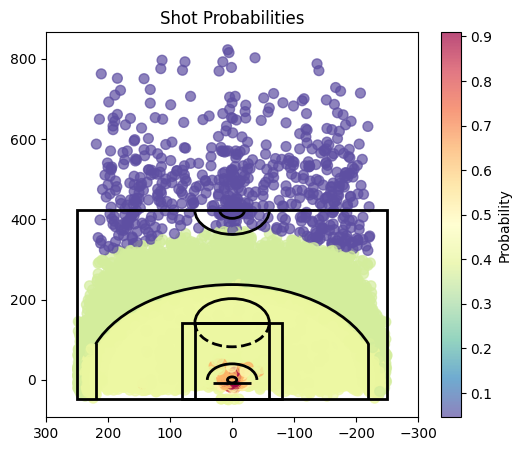

In [34]:
# Assume you have X_test, y_pred_proba, and a function draw_court

# Create a figure with a single subplot
fig, ax = plt.subplots(figsize=(6, 5))

y_probs = ada_model.predict(X_test)

# Scatter plot with color representing predicted probabilities
scatter = ax.scatter(X_test.LOC_X * 10, (X_test.LOC_Y - 5) * 10, c=y_probs, cmap='Spectral_r', s=50, alpha=0.7)
draw_court(outer_lines=True, ax=ax)  # Assuming draw_court accepts an ax parameter
ax.set_xlim(300, -300)
ax.set_title('Shot Probabilities')

# Add colorbar for the predicted probabilities
cbar = fig.colorbar(scatter, ax=ax, orientation='vertical')
cbar.set_label('Probability')

# Show the plot
plt.show()

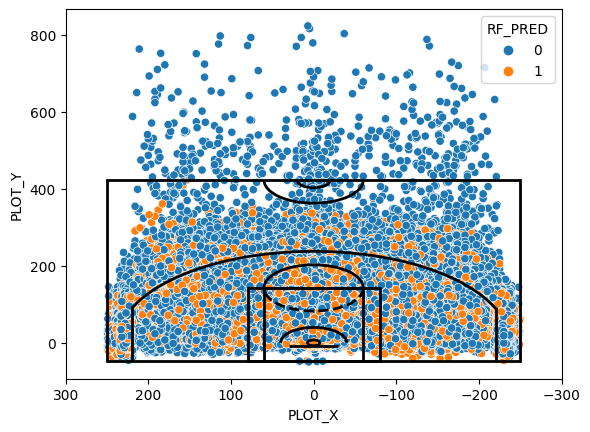

In [35]:
test_copy = X_test.copy()
threshold = 0.5
test_copy['PROB'] = rf_model.predict(X_test)
test_copy['RF_PRED'] = (test_copy['PROB'] > threshold).astype(int)

test_copy["PLOT_X"] = test_copy['LOC_X'] * 10
test_copy["PLOT_Y"] = (test_copy['LOC_Y'] - 5) * 10
sns.scatterplot(x='PLOT_X', y='PLOT_Y', data=test_copy, hue='RF_PRED')
draw_court(outer_lines=True)
# Descending values along the axis from left to right
plt.xlim(300,-300)
plt.show()

# Decision Tree

*Classifier*

In [36]:
data = shot_df[shot_df["SEASON_1"].isin([2017,2018,2019,2020,2021,2022])]
test_data = shot_df[shot_df["SEASON_1"].isin([2023])]
columns = ["LOC_X", 
           "LOC_Y", 
           "SHOT_DISTANCE", 
           "ACTION_GROUP", 
           "TIME_LEFT_QUARTER", 
           "TIME_LEFT_GAME",
           "POSITION_GROUP",
           "BASIC_ZONE",
           "SHOT_TYPE",
           "DEF_RATING",
           "HOME",
           "CLUTCH",
           "BUZZER"]
X_train = pd.get_dummies(data[columns])
X_test = pd.get_dummies(test_data[columns])
y_train = data["SHOT_MADE"]
y_test = test_data["SHOT_MADE"]
plot_x = 10 * test_data["LOC_X"]
plot_y = 10 * (test_data["LOC_Y"] - 5)

In [37]:
clf = DecisionTreeClassifier(min_impurity_decrease=0.001)
clf.fit(X_train, y_train)
y_pred_clf = clf.predict(X_test)
eval_score = accuracy_score(y_test, y_pred_clf)

print("Accuracy:", eval_score)

Accuracy: 0.6235199337077617


In [38]:
d = dict(zip(X_train.columns, clf.feature_importances_))
clf_feat_imp = sorted(d.items(), key=lambda x: x[1], reverse=True)

clf_feat_imp = pd.DataFrame(clf_feat_imp, columns=["Feature", "Importance"])
clf_feat_imp[clf_feat_imp["Importance"] > 0]

Feature  Importance
0           SHOT_DISTANCE    0.808869
1  ACTION_GROUP_dunk shot    0.191131

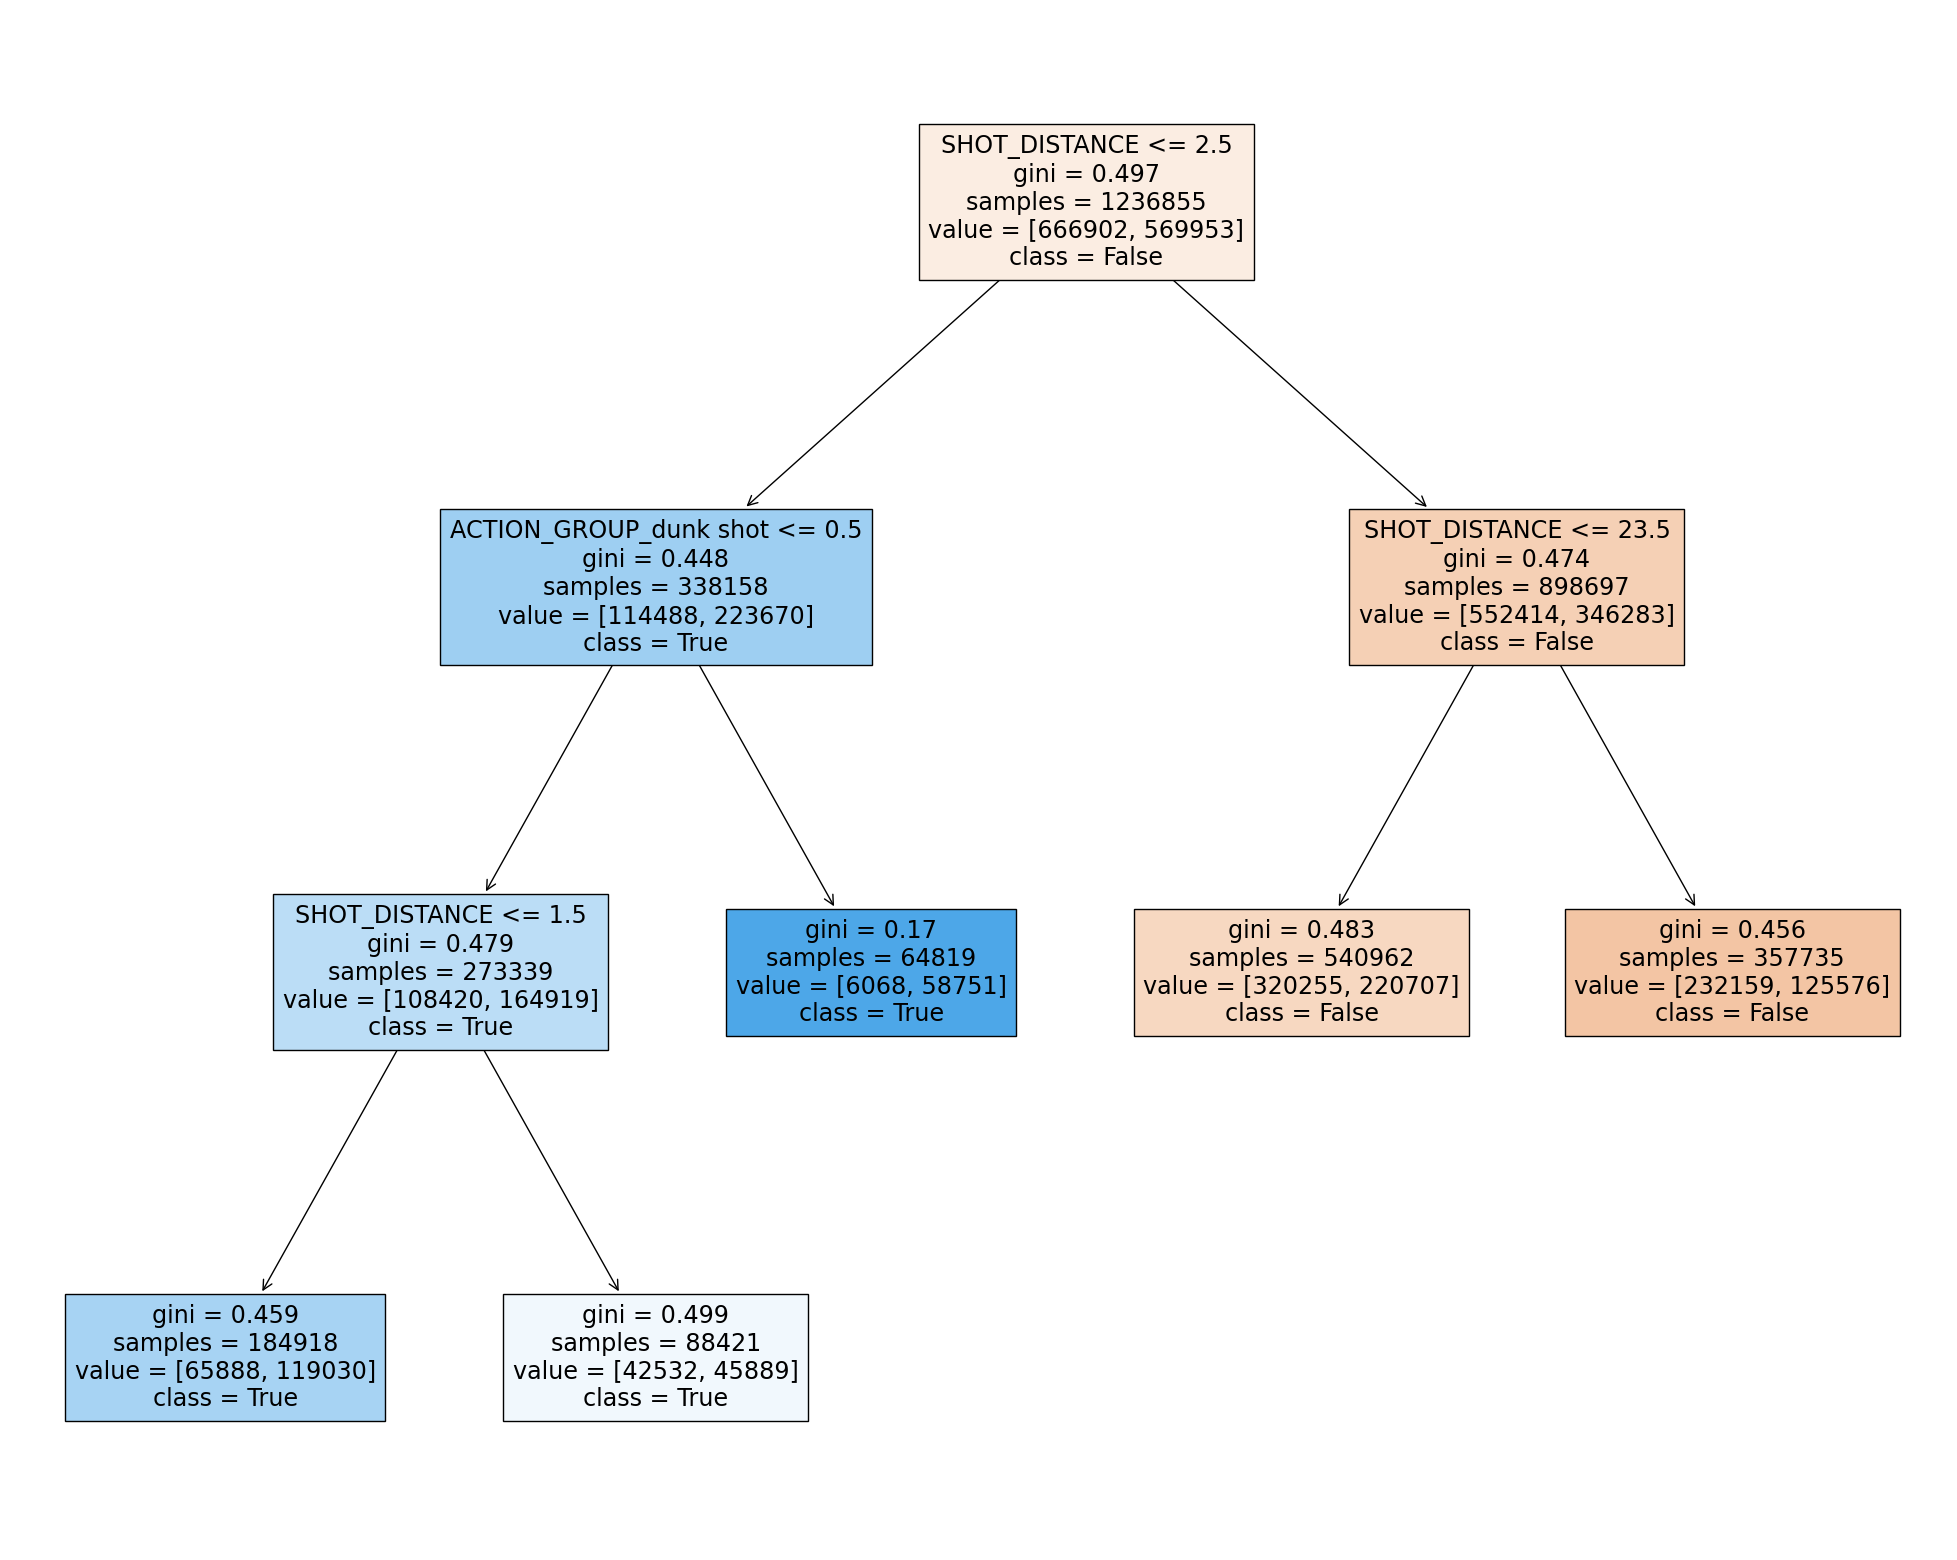

In [39]:
fig = plt.figure(figsize=(25,20))
tree.plot_tree(clf,
               feature_names=list(X_train.columns),  
               class_names=["False", "True"],
               filled=True)
plt.savefig("dt_clf.jpg")
plt.show()

*Regressor*

In [40]:
reg = DecisionTreeRegressor(min_impurity_decrease=0.0003)
reg.fit(X_train, y_train)
y_pred_reg = reg.predict(X_test)
eval_score = mean_squared_error(y_test, y_pred_reg)

print("MSE:", eval_score)
print("MAE:", mean_absolute_error(y_test, y_pred_reg))
print("Accuracy:", accuracy_score(y_test, (y_pred_reg > 0.5).astype(int)))
print("RMSE:", math.sqrt(eval_score))

MSE: 0.22859253657450762
MAE: 0.45634168493523847
Accuracy: 0.6235199337077617
RMSE: 0.478113518502152


In [41]:
d = dict(zip(X_train.columns, reg.feature_importances_))
reg_feat_imp = sorted(d.items(), key=lambda x: x[1], reverse=True)

reg_feat_imp = pd.DataFrame(reg_feat_imp, columns=["Feature", "Importance"])
reg_feat_imp[reg_feat_imp["Importance"] > 0]

Feature  Importance
0           SHOT_DISTANCE    0.794569
1  ACTION_GROUP_dunk shot    0.187752
2       TIME_LEFT_QUARTER    0.017679

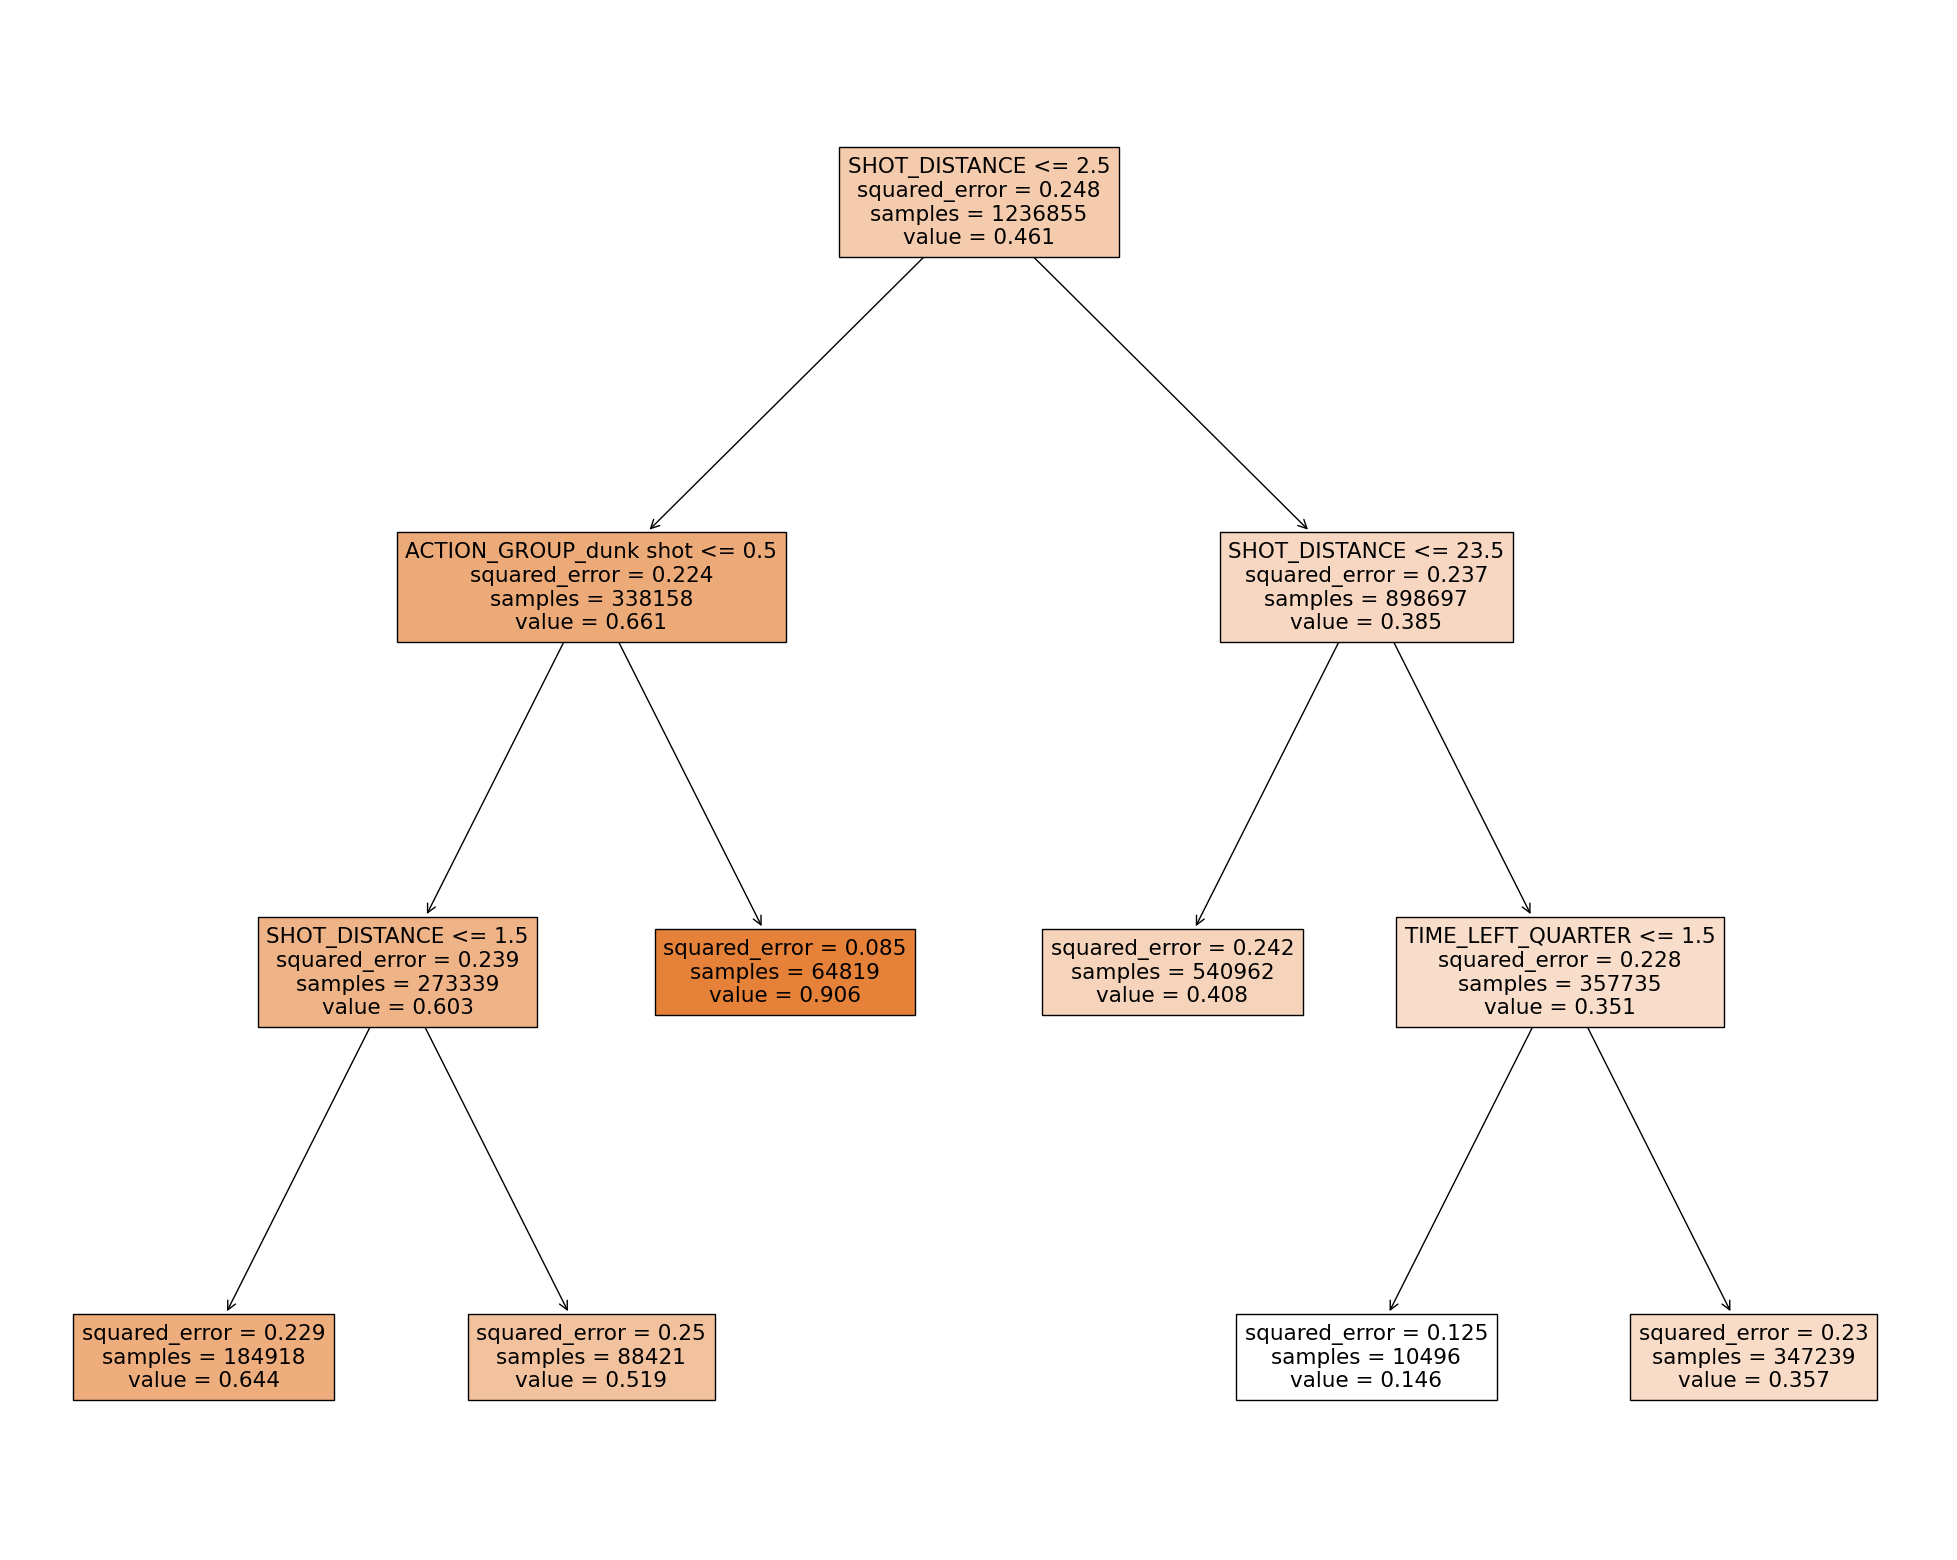

In [42]:
fig = plt.figure(figsize=(25,20))
tree.plot_tree(reg,
               feature_names=list(X_train.columns),  
#                class_names=["False", "True"],
               filled=True)
plt.savefig("dt_reg.jpg")
plt.show()

In [43]:
X_test["Prediction"] = y_pred_clf
X_test["DT_REG_PRED"] = y_pred_reg
X_test["PLOT_X"] = plot_x
X_test["PLOT_Y"] = plot_y
X_test["Shot Made"] = y_test

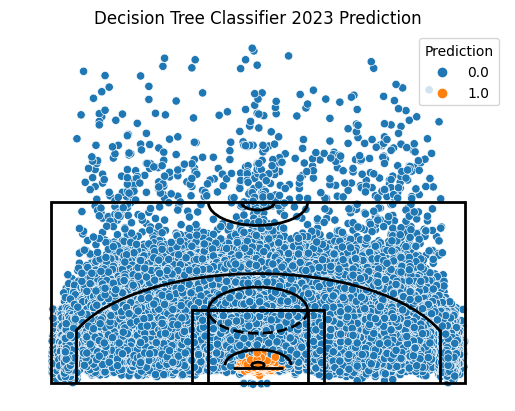

In [44]:
sns.scatterplot(x="PLOT_X", y="PLOT_Y", data=X_test, hue="Prediction")
draw_court(outer_lines=True)
plt.title("Decision Tree Classifier 2023 Prediction")
plt.xlim(300,-300)
plt.axis('off')
plt.show()

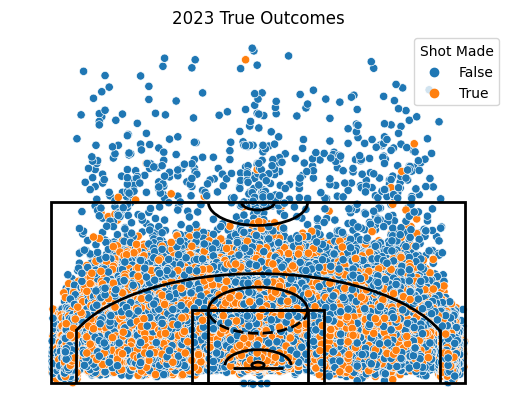

In [45]:
sns.scatterplot(x="PLOT_X", y="PLOT_Y", data=X_test, hue="Shot Made")
draw_court(outer_lines=True)
plt.title("2023 True Outcomes")
plt.xlim(300,-300)
plt.axis('off')
plt.show()

# Neural Network

In [46]:
train_data = shot_df[shot_df["SEASON_1"].isin([2017,2018,2019,2020,2021,2022])]
test_data = shot_df[shot_df["SEASON_1"].isin([2023])]

In [47]:
columns = ["LOC_X", 
           "LOC_Y", 
           "SHOT_DISTANCE", 
           "ACTION_GROUP", 
           "TIME_LEFT_QUARTER", 
           "TIME_LEFT_GAME",
           "POSITION_GROUP",
           "BASIC_ZONE",
           "SHOT_TYPE",
           "DEF_RATING",
           "HOME",
           "CLUTCH",
           "BUZZER"]
X_train = pd.get_dummies(train_data[columns]).values
X_test = pd.get_dummies(test_data[columns]).values
y_train = train_data["SHOT_MADE"].values
y_test = test_data["SHOT_MADE"].values

In [48]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [49]:
model = Sequential()
model.add(Dense(128, activation='relu', input_shape=(X_train.shape[1],)))
model.add(Dropout(0.2))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(32, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(1, activation='linear'))

In [50]:
tf.random.set_seed(42)
model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')
# early_stopping = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)
model.fit(X_train, y_train, epochs=50, batch_size=128, validation_split=0.2, verbose=2)

Epoch 1/50
7731/7731 - 7s - loss: 0.2317 - val_loss: 0.2293 - 7s/epoch - 926us/step
Epoch 2/50
7731/7731 - 7s - loss: 0.2281 - val_loss: 0.2284 - 7s/epoch - 856us/step
Epoch 3/50
7731/7731 - 7s - loss: 0.2276 - val_loss: 0.2292 - 7s/epoch - 852us/step
Epoch 4/50
7731/7731 - 7s - loss: 0.2275 - val_loss: 0.2292 - 7s/epoch - 853us/step
Epoch 5/50
7731/7731 - 7s - loss: 0.2273 - val_loss: 0.2292 - 7s/epoch - 852us/step
Epoch 6/50
7731/7731 - 7s - loss: 0.2273 - val_loss: 0.2289 - 7s/epoch - 851us/step
Epoch 7/50
7731/7731 - 7s - loss: 0.2273 - val_loss: 0.2289 - 7s/epoch - 854us/step
Epoch 8/50
7731/7731 - 7s - loss: 0.2272 - val_loss: 0.2287 - 7s/epoch - 852us/step
Epoch 9/50
7731/7731 - 7s - loss: 0.2272 - val_loss: 0.2290 - 7s/epoch - 851us/step
Epoch 10/50
7731/7731 - 7s - loss: 0.2272 - val_loss: 0.2287 - 7s/epoch - 852us/step
Epoch 11/50
7731/7731 - 7s - loss: 0.2271 - val_loss: 0.2288 - 7s/epoch - 853us/step
Epoch 12/50
7731/7731 - 7s - loss: 0.2271 - val_loss: 0.2292 - 7s/epoch - 

In [51]:
loss = model.evaluate(X_test, y_test, verbose=0)
print(f'Mean Squared Error on Test Set: {loss}')

Mean Squared Error on Test Set: 0.22658327221870422


In [52]:
y_pred = model.predict(X_test)

6789/6789 [==============================] - 2s 238us/step


In [53]:
y_pred_binary = (y_pred > 0.5).astype(int)
accuracy_score(y_test, y_pred_binary)

0.6267654912070711

In [54]:
mean_absolute_error(y_test, y_pred)

0.45635447

In [55]:
math.sqrt(loss)

0.4760076388238998

In [56]:
y_test = y_test.astype("float32")
y_pred = y_pred.ravel()
absolute_errors = np.abs(y_test - y_pred)

In [62]:
test_data.loc[:, "Absolute Error"] = absolute_errors
test_data.loc[:, "Probability"] = y_pred
test_data.loc[:, "Prediction"] = (y_pred > 0.5)

test_data.loc[:, 'POINT_VALUE'] = test_data['SHOT_TYPE'].map(lambda x: int(x[0]))
test_data.loc[:, "EV"] = test_data["Probability"] * test_data["POINT_VALUE"]

test_data.loc[:, "PLOT_X"] = 10 * test_data["LOC_X"]
test_data.loc[:, "PLOT_Y"] = 10 * (test_data["LOC_Y"] - 5)

/var/folders/5d/x77440zn3c332t6t3c7wdsnm0000gn/T/ipykernel_41072/4144708410.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data.loc[:, "Absolute Error"] = absolute_errors
/var/folders/5d/x77440zn3c332t6t3c7wdsnm0000gn/T/ipykernel_41072/4144708410.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data.loc[:, "Probability"] = y_pred
/var/folders/5d/x77440zn3c332t6t3c7wdsnm0000gn/T/ipykernel_41072/4144708410.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a

In [63]:
# MSE
mean_squared_error(test_data["SHOT_VALUE"], test_data["EV"])

1.3510598030123602

In [64]:
# RMSE
math.sqrt(mean_squared_error(test_data["SHOT_VALUE"], test_data["EV"]))

1.162350980991697

In [65]:
# MAE
mean_absolute_error(test_data["SHOT_VALUE"], test_data["EV"])

1.0923522992276533

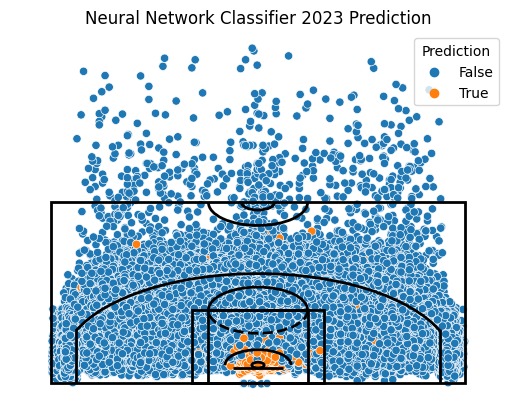

In [66]:
sns.scatterplot(x="PLOT_X", y="PLOT_Y", data=test_data, hue="Prediction")
draw_court(outer_lines=True)
plt.title("Neural Network Classifier 2023 Prediction")
plt.xlim(300,-300)
plt.axis('off')
plt.show()

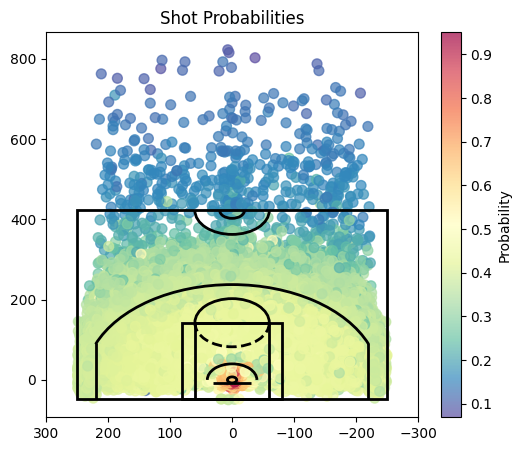

In [67]:
# Create a figure with a single subplot
fig, ax = plt.subplots(figsize=(6, 5))

# Scatter plot with color representing predicted probabilities
scatter = ax.scatter(test_data.PLOT_X, test_data.PLOT_Y, c=y_pred, cmap='Spectral_r', s=50, alpha=0.7)
draw_court(outer_lines=True, ax=ax)  # Assuming draw_court accepts an ax parameter
ax.set_xlim(300, -300)
ax.set_title('Shot Probabilities')

# Add colorbar for the predicted probabilities
cbar = fig.colorbar(scatter, ax=ax, orientation='vertical')
cbar.set_label('Probability')

# Show the plot
plt.show()

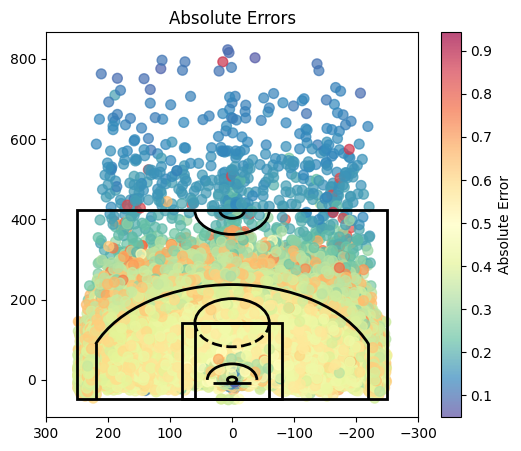

In [68]:
# Create a figure with a single subplot
fig, ax = plt.subplots(figsize=(6, 5))

# Scatter plot with color representing predicted probabilities
scatter = ax.scatter(test_data.PLOT_X, test_data.PLOT_Y, c=absolute_errors, cmap='Spectral_r', s=50, alpha=0.7)
draw_court(outer_lines=True, ax=ax)  # Assuming draw_court accepts an ax parameter
ax.set_xlim(300, -300)
ax.set_title('Absolute Errors')

# Add colorbar for the predicted probabilities
cbar = fig.colorbar(scatter, ax=ax, orientation='vertical')
cbar.set_label('Absolute Error')

# Show the plot
plt.show()

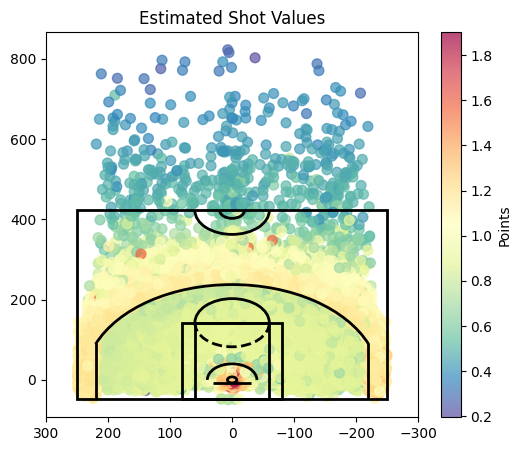

In [69]:
# Create a figure with a single subplot
fig, ax = plt.subplots(figsize=(6, 5))

# Scatter plot with color representing predicted probabilities
scatter = ax.scatter(test_data.PLOT_X, test_data.PLOT_Y, c=test_data.EV, cmap='Spectral_r', s=50, alpha=0.7)
draw_court(outer_lines=True, ax=ax)  # Assuming draw_court accepts an ax parameter
ax.set_xlim(300, -300)
ax.set_title('Estimated Shot Values')

# Add colorbar for the predicted probabilities
cbar = fig.colorbar(scatter, ax=ax, orientation='vertical')
cbar.set_label('Points')

# Show the plot
plt.show()

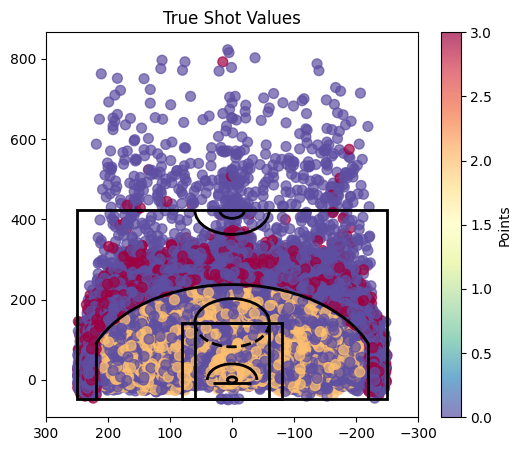

In [70]:
# Create a figure with a single subplot
fig, ax = plt.subplots(figsize=(6, 5))

# Scatter plot with color representing predicted probabilities
scatter = ax.scatter(test_data.PLOT_X, test_data.PLOT_Y, c=test_data.SHOT_VALUE, cmap='Spectral_r', s=50, alpha=0.7)
draw_court(outer_lines=True, ax=ax)  # Assuming draw_court accepts an ax parameter
ax.set_xlim(300, -300)
ax.set_title('True Shot Values')

# Add colorbar for the predicted probabilities
cbar = fig.colorbar(scatter, ax=ax, orientation='vertical')
cbar.set_label('Points')

# Show the plot
plt.show()

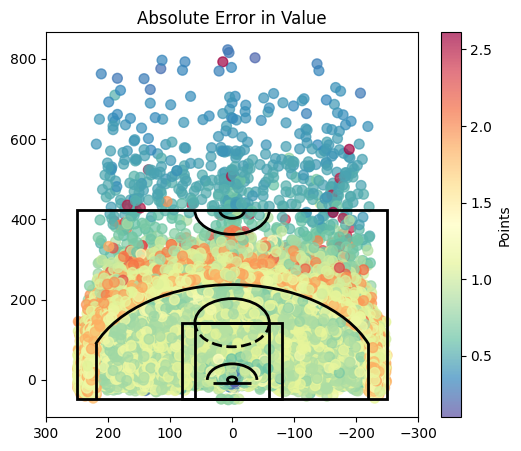

In [71]:
# Create a figure with a single subplot
fig, ax = plt.subplots(figsize=(6, 5))

# Scatter plot with color representing predicted probabilities
scatter = ax.scatter(test_data.PLOT_X, test_data.PLOT_Y, c=np.abs(test_data.SHOT_VALUE-test_data.EV), cmap='Spectral_r', s=50, alpha=0.7)
draw_court(outer_lines=True, ax=ax)  # Assuming draw_court accepts an ax parameter
ax.set_xlim(300, -300)
ax.set_title('Absolute Error in Value')

# Add colorbar for the predicted probabilities
cbar = fig.colorbar(scatter, ax=ax, orientation='vertical')
cbar.set_label('Points')

# Show the plot
plt.show()

# Player Evaluation (Neural Network)

In [72]:
made_shots = test_data[test_data['SHOT_MADE'] == 1]
total_points_made = made_shots['POINT_VALUE'].sum()

total_ev = test_data['EV'].sum()

print(f'Total Points Made: {total_points_made}')
print(f'Total Expected Values (EV): {total_ev}')

Total Points Made: 236879
Total Expected Values (EV): 235374.49500979483


In [73]:
def player_evaluation(df, player_name, start_date, end_date):
    """
    Calculate how much more a player scored compared to the expected value (EV) of his shots.

    Parameters:
    - df: DataFrame containing the relevant columns.
    - player_name: Name of the player to evaluate.
    - start_date: Start date for the evaluation period.
    - end_date: End date for the evaluation period.

    Returns:
    - player_evaluation_df: DataFrame with player evaluation results.
    """
    df['GAME_DATE'] = pd.to_datetime(df['GAME_DATE'])
    shots = df[(df['PLAYER_NAME'] == player_name) & (df['GAME_DATE'] >= start_date) & (df['GAME_DATE'] <= end_date)].copy()

    made_shots = shots[shots['SHOT_MADE'] == 1].copy()
    total_points_made = made_shots['POINT_VALUE'].sum()
    total_ev = shots['EV'].sum()

    score_difference = total_points_made - total_ev

    average_points_per_shot = total_points_made / len(shots) if len(shots) > 0 else 0
    average_ev_per_shot = total_ev / len(shots) if len(shots) > 0 else 0

    player_evaluation_df = pd.DataFrame({
        'Player_Name': [player_name],
        'Start_Date': [start_date],
        'End_Date': [end_date],
        'Total_Points_Made': [total_points_made],
        'Total_EV': [total_ev],
        'Score_Difference': [score_difference],
        'Average_Points_Per_Shot': [average_points_per_shot],
        'Average_EV_Per_Shot': [average_ev_per_shot],
        'Per_Shot_Difference': [average_points_per_shot - average_ev_per_shot]
    })

    return player_evaluation_df

In [74]:
player_name = 'Stephen Curry'
start_date = '10-19-2022'
end_date = '04-09-2023'

evaluation_results = player_evaluation(test_data, player_name, start_date, end_date)
evaluation_results

/var/folders/5d/x77440zn3c332t6t3c7wdsnm0000gn/T/ipykernel_41072/978909831.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['GAME_DATE'] = pd.to_datetime(df['GAME_DATE'])


Player_Name  Start_Date    End_Date  Total_Points_Made     Total_EV  \
0  Stephen Curry  10-19-2022  04-09-2023               1367  1120.973896   

   Score_Difference  Average_Points_Per_Shot  Average_EV_Per_Shot  \
0        246.026104                 1.230423             1.008977   

   Per_Shot_Difference  
0             0.221446

In [75]:
players_to_evaluate = test_data['PLAYER_NAME'].unique().tolist()
start_date = '10-19-2022'
end_date = '04-09-2023'

player_evaluations = []

for player_name in players_to_evaluate:
    evaluation_results = player_evaluation(test_data, player_name, start_date, end_date)
    player_evaluations.append(evaluation_results)

results_df = pd.concat(player_evaluations, ignore_index=True)

/var/folders/5d/x77440zn3c332t6t3c7wdsnm0000gn/T/ipykernel_41072/978909831.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['GAME_DATE'] = pd.to_datetime(df['GAME_DATE'])
/var/folders/5d/x77440zn3c332t6t3c7wdsnm0000gn/T/ipykernel_41072/978909831.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['GAME_DATE'] = pd.to_datetime(df['GAME_DATE'])
/var/folders/5d/x77440zn3c332t6t3c7wdsnm0000gn/T/ipykernel_41072/978909831.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice 

/var/folders/5d/x77440zn3c332t6t3c7wdsnm0000gn/T/ipykernel_41072/978909831.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['GAME_DATE'] = pd.to_datetime(df['GAME_DATE'])
/var/folders/5d/x77440zn3c332t6t3c7wdsnm0000gn/T/ipykernel_41072/978909831.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['GAME_DATE'] = pd.to_datetime(df['GAME_DATE'])
/var/folders/5d/x77440zn3c332t6t3c7wdsnm0000gn/T/ipykernel_41072/978909831.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice 

/var/folders/5d/x77440zn3c332t6t3c7wdsnm0000gn/T/ipykernel_41072/978909831.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['GAME_DATE'] = pd.to_datetime(df['GAME_DATE'])
/var/folders/5d/x77440zn3c332t6t3c7wdsnm0000gn/T/ipykernel_41072/978909831.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['GAME_DATE'] = pd.to_datetime(df['GAME_DATE'])
/var/folders/5d/x77440zn3c332t6t3c7wdsnm0000gn/T/ipykernel_41072/978909831.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice 

/var/folders/5d/x77440zn3c332t6t3c7wdsnm0000gn/T/ipykernel_41072/978909831.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['GAME_DATE'] = pd.to_datetime(df['GAME_DATE'])
/var/folders/5d/x77440zn3c332t6t3c7wdsnm0000gn/T/ipykernel_41072/978909831.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['GAME_DATE'] = pd.to_datetime(df['GAME_DATE'])
/var/folders/5d/x77440zn3c332t6t3c7wdsnm0000gn/T/ipykernel_41072/978909831.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice 

/var/folders/5d/x77440zn3c332t6t3c7wdsnm0000gn/T/ipykernel_41072/978909831.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['GAME_DATE'] = pd.to_datetime(df['GAME_DATE'])
/var/folders/5d/x77440zn3c332t6t3c7wdsnm0000gn/T/ipykernel_41072/978909831.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['GAME_DATE'] = pd.to_datetime(df['GAME_DATE'])
/var/folders/5d/x77440zn3c332t6t3c7wdsnm0000gn/T/ipykernel_41072/978909831.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice 

/var/folders/5d/x77440zn3c332t6t3c7wdsnm0000gn/T/ipykernel_41072/978909831.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['GAME_DATE'] = pd.to_datetime(df['GAME_DATE'])
/var/folders/5d/x77440zn3c332t6t3c7wdsnm0000gn/T/ipykernel_41072/978909831.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['GAME_DATE'] = pd.to_datetime(df['GAME_DATE'])
/var/folders/5d/x77440zn3c332t6t3c7wdsnm0000gn/T/ipykernel_41072/978909831.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice 

/var/folders/5d/x77440zn3c332t6t3c7wdsnm0000gn/T/ipykernel_41072/978909831.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['GAME_DATE'] = pd.to_datetime(df['GAME_DATE'])
/var/folders/5d/x77440zn3c332t6t3c7wdsnm0000gn/T/ipykernel_41072/978909831.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['GAME_DATE'] = pd.to_datetime(df['GAME_DATE'])
/var/folders/5d/x77440zn3c332t6t3c7wdsnm0000gn/T/ipykernel_41072/978909831.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice 

/var/folders/5d/x77440zn3c332t6t3c7wdsnm0000gn/T/ipykernel_41072/978909831.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['GAME_DATE'] = pd.to_datetime(df['GAME_DATE'])
/var/folders/5d/x77440zn3c332t6t3c7wdsnm0000gn/T/ipykernel_41072/978909831.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['GAME_DATE'] = pd.to_datetime(df['GAME_DATE'])
/var/folders/5d/x77440zn3c332t6t3c7wdsnm0000gn/T/ipykernel_41072/978909831.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice 

/var/folders/5d/x77440zn3c332t6t3c7wdsnm0000gn/T/ipykernel_41072/978909831.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['GAME_DATE'] = pd.to_datetime(df['GAME_DATE'])
/var/folders/5d/x77440zn3c332t6t3c7wdsnm0000gn/T/ipykernel_41072/978909831.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['GAME_DATE'] = pd.to_datetime(df['GAME_DATE'])
/var/folders/5d/x77440zn3c332t6t3c7wdsnm0000gn/T/ipykernel_41072/978909831.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice 

/var/folders/5d/x77440zn3c332t6t3c7wdsnm0000gn/T/ipykernel_41072/978909831.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['GAME_DATE'] = pd.to_datetime(df['GAME_DATE'])
/var/folders/5d/x77440zn3c332t6t3c7wdsnm0000gn/T/ipykernel_41072/978909831.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['GAME_DATE'] = pd.to_datetime(df['GAME_DATE'])
/var/folders/5d/x77440zn3c332t6t3c7wdsnm0000gn/T/ipykernel_41072/978909831.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice 

/var/folders/5d/x77440zn3c332t6t3c7wdsnm0000gn/T/ipykernel_41072/978909831.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['GAME_DATE'] = pd.to_datetime(df['GAME_DATE'])
/var/folders/5d/x77440zn3c332t6t3c7wdsnm0000gn/T/ipykernel_41072/978909831.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['GAME_DATE'] = pd.to_datetime(df['GAME_DATE'])
/var/folders/5d/x77440zn3c332t6t3c7wdsnm0000gn/T/ipykernel_41072/978909831.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice 

/var/folders/5d/x77440zn3c332t6t3c7wdsnm0000gn/T/ipykernel_41072/978909831.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['GAME_DATE'] = pd.to_datetime(df['GAME_DATE'])
/var/folders/5d/x77440zn3c332t6t3c7wdsnm0000gn/T/ipykernel_41072/978909831.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['GAME_DATE'] = pd.to_datetime(df['GAME_DATE'])
/var/folders/5d/x77440zn3c332t6t3c7wdsnm0000gn/T/ipykernel_41072/978909831.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice 

/var/folders/5d/x77440zn3c332t6t3c7wdsnm0000gn/T/ipykernel_41072/978909831.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['GAME_DATE'] = pd.to_datetime(df['GAME_DATE'])
/var/folders/5d/x77440zn3c332t6t3c7wdsnm0000gn/T/ipykernel_41072/978909831.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['GAME_DATE'] = pd.to_datetime(df['GAME_DATE'])
/var/folders/5d/x77440zn3c332t6t3c7wdsnm0000gn/T/ipykernel_41072/978909831.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice 

/var/folders/5d/x77440zn3c332t6t3c7wdsnm0000gn/T/ipykernel_41072/978909831.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['GAME_DATE'] = pd.to_datetime(df['GAME_DATE'])
/var/folders/5d/x77440zn3c332t6t3c7wdsnm0000gn/T/ipykernel_41072/978909831.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['GAME_DATE'] = pd.to_datetime(df['GAME_DATE'])
/var/folders/5d/x77440zn3c332t6t3c7wdsnm0000gn/T/ipykernel_41072/978909831.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice 

/var/folders/5d/x77440zn3c332t6t3c7wdsnm0000gn/T/ipykernel_41072/978909831.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['GAME_DATE'] = pd.to_datetime(df['GAME_DATE'])
/var/folders/5d/x77440zn3c332t6t3c7wdsnm0000gn/T/ipykernel_41072/978909831.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['GAME_DATE'] = pd.to_datetime(df['GAME_DATE'])
/var/folders/5d/x77440zn3c332t6t3c7wdsnm0000gn/T/ipykernel_41072/978909831.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice 

/var/folders/5d/x77440zn3c332t6t3c7wdsnm0000gn/T/ipykernel_41072/978909831.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['GAME_DATE'] = pd.to_datetime(df['GAME_DATE'])
/var/folders/5d/x77440zn3c332t6t3c7wdsnm0000gn/T/ipykernel_41072/978909831.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['GAME_DATE'] = pd.to_datetime(df['GAME_DATE'])
/var/folders/5d/x77440zn3c332t6t3c7wdsnm0000gn/T/ipykernel_41072/978909831.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice 

/var/folders/5d/x77440zn3c332t6t3c7wdsnm0000gn/T/ipykernel_41072/978909831.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['GAME_DATE'] = pd.to_datetime(df['GAME_DATE'])
/var/folders/5d/x77440zn3c332t6t3c7wdsnm0000gn/T/ipykernel_41072/978909831.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['GAME_DATE'] = pd.to_datetime(df['GAME_DATE'])
/var/folders/5d/x77440zn3c332t6t3c7wdsnm0000gn/T/ipykernel_41072/978909831.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice 

/var/folders/5d/x77440zn3c332t6t3c7wdsnm0000gn/T/ipykernel_41072/978909831.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['GAME_DATE'] = pd.to_datetime(df['GAME_DATE'])
/var/folders/5d/x77440zn3c332t6t3c7wdsnm0000gn/T/ipykernel_41072/978909831.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['GAME_DATE'] = pd.to_datetime(df['GAME_DATE'])
/var/folders/5d/x77440zn3c332t6t3c7wdsnm0000gn/T/ipykernel_41072/978909831.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice 

/var/folders/5d/x77440zn3c332t6t3c7wdsnm0000gn/T/ipykernel_41072/978909831.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['GAME_DATE'] = pd.to_datetime(df['GAME_DATE'])
/var/folders/5d/x77440zn3c332t6t3c7wdsnm0000gn/T/ipykernel_41072/978909831.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['GAME_DATE'] = pd.to_datetime(df['GAME_DATE'])
/var/folders/5d/x77440zn3c332t6t3c7wdsnm0000gn/T/ipykernel_41072/978909831.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice 

/var/folders/5d/x77440zn3c332t6t3c7wdsnm0000gn/T/ipykernel_41072/978909831.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['GAME_DATE'] = pd.to_datetime(df['GAME_DATE'])
/var/folders/5d/x77440zn3c332t6t3c7wdsnm0000gn/T/ipykernel_41072/978909831.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['GAME_DATE'] = pd.to_datetime(df['GAME_DATE'])
/var/folders/5d/x77440zn3c332t6t3c7wdsnm0000gn/T/ipykernel_41072/978909831.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice 

In [76]:
results_df = results_df.drop(["Start_Date", "End_Date"], axis=1)

In [77]:
# Top 20 Overall Value
round(results_df.sort_values(by='Score_Difference', ascending=False)[:20],2)

Player_Name  Total_Points_Made  Total_EV  Score_Difference  \
415       Nikola Jokic               1349   1060.52            288.48   
380      Stephen Curry               1367   1120.97            246.03   
149       Kevin Durant               1059    856.98            202.02   
87        De'Aaron Fox               1483   1333.46            149.54   
151        Joel Embiid               1503   1359.87            143.13   
426        Luka Doncic               1623   1482.96            140.04   
444       Kyrie Irving               1376   1238.50            137.50   
88    Domantas Sabonis               1185   1052.69            132.31   
464      DeMar DeRozan               1360   1236.65            123.35   
330      Kawhi Leonard                996    878.78            117.22   
207      Jalen Brunson               1308   1193.22            114.78   
447   Donovan Mitchell               1603   1492.19            110.81   
91       Kevin Huerter               1045    934.26            110.74   
345        Buddy Hield               1238   1127.97            110.03   
396   Bojan Bogdanovic               1005    896.16            108.84   
133       Devin Booker               1165   1065.57             99.43   
64        Jakob Poeltl                778    680.04             97.96   
306       Luke Kennard                509    411.70             97.30   
343  Tyrese Haliburton                985    888.90             96.10   
0         Bradley Beal                968    871.92             96.08   

     Average_Points_Per_Shot  Average_EV_Per_Shot  Per_Shot_Difference  
415                     1.32                 1.04                 0.28  
380                     1.23                 1.01                 0.22  
149                     1.23                 0.99                 0.23  
87                      1.11                 1.00                 0.11  
151                     1.15                 1.04                 0.11  
426                     1.12                 1.02                 0.10  
444                     1.14                 1.03                 0.11  
88                      1.26                 1.12                 0.14  
464                     1.04                 0.95                 0.09  
330                     1.14                 1.01                 0.13  
207                     1.09                 1.00                 0.10  
447                     1.14                 1.06                 0.08  
91                      1.21                 1.08                 0.13  
345                     1.19                 1.09                 0.11  
396                     1.14                 1.02                 0.12  
133                     1.09                 1.00                 0.09  
64                      1.26                 1.10                 0.16  
306                     1.33                 1.08                 0.25  
343                     1.17                 1.06                 0.11  
0                       1.10                 0.99                 0.11

In [78]:
# Bottom 20
round(results_df.sort_values(by='Score_Difference', ascending=True)[:20], 2)

Player_Name  Total_Points_Made  Total_EV  Score_Difference  \
191        Luguentz Dort                813    975.66           -162.66   
206           RJ Barrett               1141   1272.01           -131.01   
400        Killian Hayes                694    814.94           -120.94   
168       Paolo Banchero               1043   1145.90           -102.90   
302        Dillon Brooks                927   1028.80           -101.80   
48        Scottie Barnes                989   1089.23           -100.23   
366           Tari Eason                651    747.22            -96.22   
359          Jalen Green               1319   1411.13            -92.13   
480         Terry Rozier               1151   1242.87            -91.87   
360     Jabari Smith Jr.                848    939.61            -91.61   
479      Kelly Oubre Jr.                814    903.57            -89.57   
429  Dorian Finney-Smith                506    593.43            -87.43   
68         Jeremy Sochan                533    620.16            -87.16   
139          Josh Okogie                390    476.16            -86.16   
311    Russell Westbrook                938   1023.35            -85.35   
393           Jaden Ivey                938   1020.36            -82.36   
483     Dennis Smith Jr.                396    476.51            -80.51   
347   Bennedict Mathurin                926   1004.14            -78.14   
350       Oshae Brissett                294    360.03            -66.03   
77          Blake Wesley                158    222.49            -64.49   

     Average_Points_Per_Shot  Average_EV_Per_Shot  Per_Shot_Difference  
191                     0.93                 1.12                -0.19  
206                     0.97                 1.08                -0.11  
400                     0.85                 1.00                -0.15  
168                     0.93                 1.02                -0.09  
302                     0.94                 1.04                -0.10  
48                      0.97                 1.07                -0.10  
366                     0.99                 1.13                -0.15  
359                     0.97                 1.04                -0.07  
480                     0.97                 1.05                -0.08  
360                     0.95                 1.05                -0.10  
479                     0.99                 1.10                -0.11  
429                     1.01                 1.18                -0.17  
68                      0.97                 1.12                -0.16  
139                     0.94                 1.15                -0.21  
311                     0.96                 1.05                -0.09  
393                     0.95                 1.04                -0.08  
483                     0.88                 1.05                -0.18  
347                     0.97                 1.06                -0.08  
350                     0.92                 1.13                -0.21  
77                      0.73                 1.03                -0.30

In [79]:
# Top 20 Per Shot
round(results_df[results_df["Total_Points_Made"] > 250].sort_values(by='Per_Shot_Difference', ascending=False)[:20],2)

Player_Name  Total_Points_Made  Total_EV  Score_Difference  \
415         Nikola Jokic               1349   1060.52            288.48   
306         Luke Kennard                509    411.70             97.30   
149         Kevin Durant               1059    856.98            202.02   
380        Stephen Curry               1367   1120.97            246.03   
521  Robert Williams III                254    219.41             34.59   
312        Austin Reaves                602    511.78             90.22   
8         Daniel Gafford                578    506.17             71.83   
293       Brandon Clarke                459    396.91             62.09   
15         Corey Kispert                745    649.27             95.73   
509           Al Horford                595    518.06             76.94   
64          Jakob Poeltl                778    680.04             97.96   
388            Ty Jerome                271    235.63             35.37   
348       T.J. McConnell                592    515.85             76.15   
515           Sam Hauser                500    443.95             56.05   
88      Domantas Sabonis               1185   1052.69            132.31   
29        Walker Kessler                597    539.85             57.15   
119      Trendon Watford                387    342.54             44.46   
330        Kawhi Leonard                996    878.78            117.22   
91         Kevin Huerter               1045    934.26            110.74   
513      Malcolm Brogdon                826    734.83             91.17   

     Average_Points_Per_Shot  Average_EV_Per_Shot  Per_Shot_Difference  
415                     1.32                 1.04                 0.28  
306                     1.33                 1.08                 0.25  
149                     1.23                 0.99                 0.23  
380                     1.23                 1.01                 0.22  
521                     1.49                 1.29                 0.20  
312                     1.24                 1.05                 0.19  
8                       1.46                 1.28                 0.18  
293                     1.32                 1.14                 0.18  
15                      1.27                 1.11                 0.16  
509                     1.26                 1.10                 0.16  
64                      1.26                 1.10                 0.16  
388                     1.12                 0.97                 0.15  
348                     1.14                 0.99                 0.15  
515                     1.26                 1.12                 0.14  
88                      1.26                 1.12                 0.14  
29                      1.44                 1.30                 0.14  
119                     1.20                 1.06                 0.14  
330                     1.14                 1.01                 0.13  
91                      1.21                 1.08                 0.13  
513                     1.15                 1.02                 0.13

In [80]:
# Bottom 20 Per Shot
round(results_df[results_df["Total_Points_Made"] > 250].sort_values(by='Per_Shot_Difference', ascending=True)[:20],2)

Player_Name  Total_Points_Made  Total_EV  Score_Difference  \
139             Josh Okogie                390    476.16            -86.16   
350          Oshae Brissett                294    360.03            -66.03   
191           Luguentz Dort                813    975.66           -162.66   
483        Dennis Smith Jr.                396    476.51            -80.51   
429     Dorian Finney-Smith                506    593.43            -87.43   
32                 Rudy Gay                251    299.49            -48.49   
344            Chris Duarte                301    355.63            -54.63   
209       Mitchell Robinson                376    421.23            -45.23   
68            Jeremy Sochan                533    620.16            -87.16   
457           Lamar Stevens                288    332.62            -44.62   
472       Derrick Jones Jr.                257    291.80            -34.80   
192  Jeremiah Robinson-Earl                257    294.42            -37.42   
400           Killian Hayes                694    814.94           -120.94   
366              Tari Eason                651    747.22            -96.22   
34        Simone Fontecchio                293    336.86            -43.86   
349          Isaiah Jackson                360    402.17            -42.17   
295             David Roddy                425    476.52            -51.52   
212              Obi Toppin                459    508.81            -49.81   
469          Andre Drummond                332    363.06            -31.06   
206              RJ Barrett               1141   1272.01           -131.01   

     Average_Points_Per_Shot  Average_EV_Per_Shot  Per_Shot_Difference  
139                     0.94                 1.15                -0.21  
350                     0.92                 1.13                -0.21  
191                     0.93                 1.12                -0.19  
483                     0.88                 1.05                -0.18  
429                     1.01                 1.18                -0.17  
32                      0.87                 1.04                -0.17  
344                     0.90                 1.07                -0.16  
209                     1.34                 1.50                -0.16  
68                      0.97                 1.12                -0.16  
457                     1.00                 1.15                -0.15  
472                     1.12                 1.27                -0.15  
192                     1.04                 1.19                -0.15  
400                     0.85                 1.00                -0.15  
366                     0.99                 1.13                -0.15  
34                      0.94                 1.08                -0.14  
349                     1.13                 1.26                -0.13  
295                     1.01                 1.13                -0.12  
212                     1.10                 1.21                -0.12  
469                     1.21                 1.33                -0.11  
206                     0.97                 1.08                -0.11

In [81]:
round(results_df[results_df["Player_Name"] == "Giannis Antetokounmpo"].sort_values(by='Per_Shot_Difference', ascending=True)[:20],2)

Player_Name  Total_Points_Made  Total_EV  Score_Difference  \
255  Giannis Antetokounmpo               1461   1468.79             -7.79   

     Average_Points_Per_Shot  Average_EV_Per_Shot  Per_Shot_Difference  
255                     1.14                 1.15                -0.01